In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LSTM,Conv3D

In [2]:
def data_handler(name):
    dataframe =pd.read_csv(name)
    dataframe['datetime'] = dataframe['year'].map(str) + '-' + dataframe['month'].map(str) + '-' + dataframe['day'].map(str)
    dataframe['datetime'] = pd.to_datetime(dataframe['datetime'])
    dataframe['datetime'] = dataframe['datetime'] + dataframe['hour'].apply(lambda x: np.timedelta64(x, 'h'))
    dataframe.set_index('datetime',inplace=True)
    dataframe.pop('TEMP')
    dataframe.pop('PRES')
    dataframe.pop('DEWP')
    dataframe.pop('RAIN')
    dataframe.pop('WSPM')
    dataframe.pop('No')
    dataframe.pop('year')
    dataframe.pop('month')
    dataframe.pop('day')
    dataframe.pop('wd')
    dataframe.pop('O3')
    dataframe.pop('hour')



    dataframe.pop('station')
    dataframe=dataframe.interpolate(methode='time')
   
    dataframe=dataframe.resample('D').mean()

    df = np.asarray(dataframe)
    return dataframe


In [157]:
X1=data_handler("PRSA_Data_Aotizhongxin_20130301-20170228.csv")

In [69]:
Channels1=X1.diff()
Channels1=Channels1.dropna()
Channels2=X1.diff(365)
Channels1=Channels1[364:]
Channels2=Channels2.dropna()

In [70]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X1)
ch1 = scaler.transform(Channels1)


In [71]:

ch3 = scaler.transform(Channels2)

In [72]:

ch2 = scaler.transform(X1[365:])

In [73]:
def to_supervised(data,dropNa = True,lag=12):
    df = pd.DataFrame(data)
    column = []
    column.append(df)
    for i in range(1,13):
        column.append(df.shift(-i))
    df = pd.concat(column,axis=1)
    df.dropna(inplace = True)
    features = 5
    df = df.values
    supervised_data = df[:,:5*12]

    return supervised_data

In [74]:
timeSteps = 12
supervised1 = to_supervised(pd.DataFrame(ch1),timeSteps)


In [75]:
# spiltting the data
# training on only first year data
features = 5
train_hours = 900
X = supervised1[:,:(features*timeSteps)]

x_train1 = X[:train_hours,:]
x_test1 = X[train_hours:len(X)-timeSteps,:]

print (x_train1.shape,x_test1.shape)

(900, 60) (172, 60)


In [76]:
supervised2 = to_supervised(pd.DataFrame(ch2),timeSteps)

In [77]:
# spiltting the data
# training on only first year data
features = 5
train_hours = 900
X = supervised2[:,:(features*timeSteps)]

x_train2 = X[:train_hours,:]
x_test2 = X[train_hours:len(X)-timeSteps,:]

print (x_train2.shape,x_test2.shape)

(900, 60) (172, 60)


In [78]:
supervised3 = to_supervised(pd.DataFrame(ch3),timeSteps)
features = 5
train_hours = 900
X = supervised3[:,:(features*timeSteps)]
print(X.shape)
x_train3 = X[:train_hours,:]
x_test3 = X[train_hours:len(X)-timeSteps,:]

print (x_train3.shape,x_test3.shape)

(1084, 60)
(900, 60) (172, 60)


In [79]:
X_train1 = x_train1.reshape(x_train1.shape[0], timeSteps, features)
X_test1 = x_test1.reshape(x_test1.shape[0], timeSteps, features)

In [80]:
X_train2 = x_train2.reshape(x_train2.shape[0], timeSteps, features)
X_test2 = x_test2.reshape(x_test2.shape[0], timeSteps, features)

In [81]:
X_train3 = x_train3.reshape(x_train3.shape[0], timeSteps, features)
X_test3 = x_test3.reshape(x_test3.shape[0], timeSteps, features)

In [82]:
import tensorflow as tf

In [83]:
train_data=tf.convert_to_tensor((X_train1,X_train2,X_train3))

In [84]:
test_data=tf.convert_to_tensor((X_test1,X_test2,X_test3))

In [85]:
y = X1[377:]
y=scaler.transform(y)

In [86]:
y=y[:,0]

In [87]:
y_train = y[:train_hours]
y_test = y[train_hours:len(y)-timeSteps]

In [88]:
len(y_train)

900

In [89]:
train_data=tf.transpose(train_data,[1,2,3,0])
test_data=tf.transpose(test_data,[1,2,3,0])

In [90]:
train_data.shape

TensorShape([900, 12, 5, 3])

In [91]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling1D, LSTM,Conv3D,Conv1D,TimeDistributed

In [176]:
first_channel = tf.keras.Input(shape=(12,5,3))

FC=TimeDistributed(Conv1D(128,5,padding='same',activation='relu'))(first_channel)
FCs=TimeDistributed(Conv1D(64,5,padding='same',activation='relu'))(FC)
FCss=TimeDistributed(Conv1D(64,5,padding='same',activation='relu'))(FCs)
#Max=TimeDistributed(MaxPooling1D(pool_size=2))(FCss)
Drop=Dropout(0.4)(FCss)

FCc=TimeDistributed(Flatten())(Drop)


X1=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50,  return_sequences=False))(FCc)

Drop2=Dropout(0.4)(X1)




X11=Dense(1)(Drop2)

In [177]:
model=tf.keras.Model(first_channel,X11)

model.compile(optimizer='adam',loss='mse')
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 12, 5, 3)]        0         
                                                                 
 time_distributed_36 (TimeDi  (None, 12, 5, 128)       2048      
 stributed)                                                      
                                                                 
 time_distributed_37 (TimeDi  (None, 12, 5, 64)        41024     
 stributed)                                                      
                                                                 
 time_distributed_38 (TimeDi  (None, 12, 5, 64)        20544     
 stributed)                                                      
                                                                 
 dropout_15 (Dropout)        (None, 12, 5, 64)         0         
                                                           

In [178]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, restore_best_weights=True)

with tf.device('/GPU:0'):
    history = model.fit(train_data,y_train, validation_data=(test_data,y_test),epochs=2000, shuffle=False,callbacks=[ early_stopping])

Epoch 1/2000
29/29 [==============================] - 12s 142ms/step - loss: 0.0179 - val_loss: 0.0262
Epoch 2/2000
29/29 [==============================] - 2s 61ms/step - loss: 0.0139 - val_loss: 0.0230
Epoch 3/2000
29/29 [==============================] - 2s 61ms/step - loss: 0.0125 - val_loss: 0.0196
Epoch 4/2000
29/29 [==============================] - 2s 68ms/step - loss: 0.0113 - val_loss: 0.0199
Epoch 5/2000
29/29 [==============================] - 2s 71ms/step - loss: 0.0120 - val_loss: 0.0197
Epoch 6/2000
29/29 [==============================] - 2s 76ms/step - loss: 0.0116 - val_loss: 0.0187
Epoch 7/2000
29/29 [==============================] - 2s 70ms/step - loss: 0.0113 - val_loss: 0.0203
Epoch 8/2000
29/29 [==============================] - 2s 77ms/step - loss: 0.0105 - val_loss: 0.0211
Epoch 9/2000
29/29 [==============================] - 2s 69ms/step - loss: 0.0107 - val_loss: 0.0171
Epoch 10/2000
29/29 [==============================] - 2s 70ms/step - loss: 0.0113 - val_

In [179]:
model.evaluate(test_data,y_test)

6/6 [==============================] - 0s 17ms/step - loss: 0.0158


0.01577613316476345

In [180]:
prediction=model.predict(test_data)

6/6 [==============================] - 2s 16ms/step


In [158]:
X=X1['PM2.5']


In [181]:
X=np.asarray(X).reshape((X.shape[0],1))

In [182]:
scaler2 = MinMaxScaler()
scaler2.fit(X)



MinMaxScaler()

In [183]:
df_predi=pd.DataFrame(y_test)

rev_trans=scaler2.inverse_transform(df_predi)

df_final=pd.DataFrame(rev_trans)

In [184]:

rev_trans1=scaler2.inverse_transform(prediction)




In [185]:
df_final[["PM2.5_pred"]]=rev_trans1

In [186]:
df_final

,0,PM2.5_pred
0,17.625000,41.251923
1,31.166667,42.287476
2,17.437500,52.556427
3,6.166667,45.430935
4,11.833333,36.394615
...,...,...
167,104.458333,87.071411
168,92.916667,120.111511
169,182.833333,105.544632
170,227.625000,225.373779


In [187]:
df_final.head(30)

,0,PM2.5_pred
0,17.625000,41.251923
1,31.166667,42.287476
2,17.437500,52.556427
3,6.166667,45.430935
4,11.833333,36.394615
5,18.458333,40.958870
6,79.833333,45.666912
7,27.000000,78.783142
8,21.742188,50.998928
9,42.820312,48.420918


<AxesSubplot:>

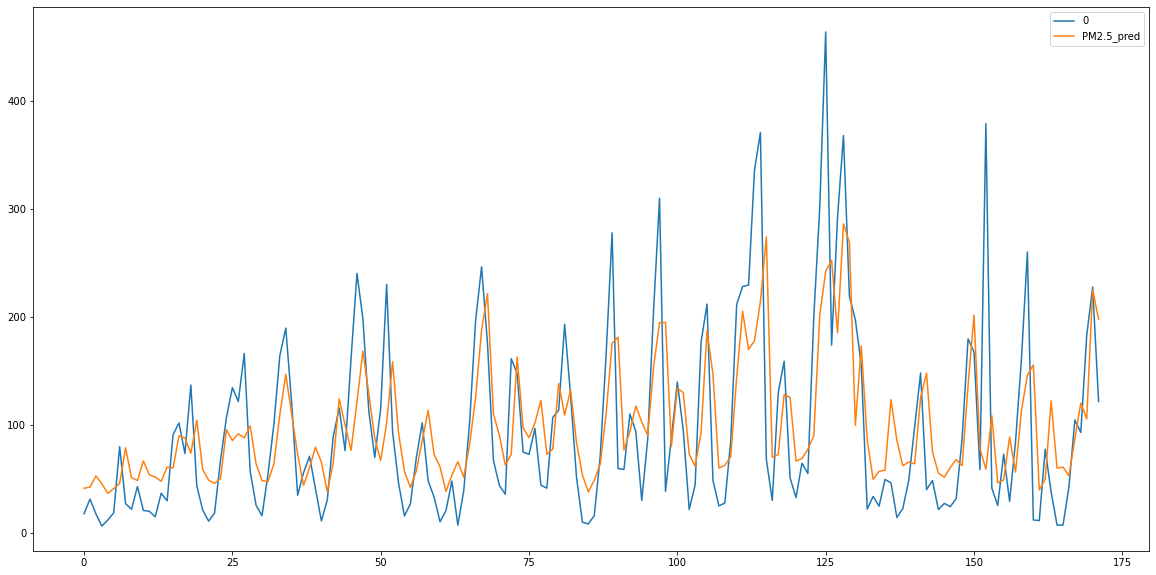

In [188]:
df_final[[0,"PM2.5_pred"]].plot(figsize=(20,10))

In [189]:
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
# calculate root mean squared error
testScore = math.sqrt(mean_squared_error(df_final[0], df_final["PM2.5_pred"]))
print('Test Score: %.2f RMSE' % (testScore))
#calculate mean aboslute error
mae=mean_absolute_error(df_final[0],df_final["PM2.5_pred"])
print('\nMae Score: %.2f ' % (mae))


Test Score: 63.86 RMSE

Mae Score: 47.30 


In [190]:
test_series = df_final[0]
# state of model performance
if testScore < test_series.std():
    print('\n[ Model performance is GOOD enough ]')
    print('\nRMSE of test prediction < Standard deviation of test dataset')
    print('%.2f' % (testScore), '<', '%.2f' % (test_series.std()))
else:
    print('\n[ Model performance is NOT GOOD enough ]')
    print('\nRMSE of test prediction > Standard deviation of test dataset')
    print('%.2f' % (testScore), '>', '%.2f' % (test_series.std()))


[ Model performance is GOOD enough ]

RMSE of test prediction < Standard deviation of test dataset
63.86 < 87.31


Text(0, 0.5, 'mse score')

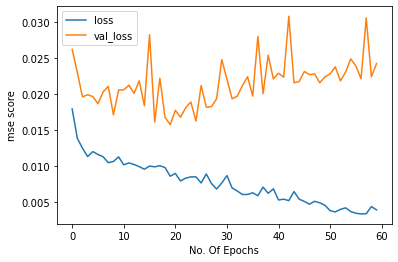

In [191]:
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val_loss")
plt.legend(loc="best")
plt.xlabel("No. Of Epochs")
plt.ylabel("mse score")

In [192]:
model.save('./modelCnnbilstmMulti-Uni')

INFO:tensorflow:Assets written to: ./modelCnnbilstmMulti-Uni\assets


INFO:tensorflow:Assets written to: ./modelCnnbilstmMulti-Uni\assets
